In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [117]:
df1 = pd.read_csv('data/split/train.csv') 
df2 = pd.read_csv('data/split/val.csv')
df = pd.concat([df1, df2])

df.reset_index(drop=True, inplace=True)

In [118]:
df.shape

(1229319, 10)

In [119]:
df.head()

id  vendor_id      pickup_datetime  passenger_count  \
0  id2793718          2  2016-06-08 07:36:19                1   
1  id3485529          2  2016-04-03 12:58:11                1   
2  id1816614          2  2016-06-05 02:49:13                5   
3  id1050851          2  2016-05-05 17:18:27                2   
4  id0140657          1  2016-05-12 17:43:38                4   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.985611        40.735943         -73.980331         40.760468   
1        -73.978394        40.764351         -73.991623         40.749859   
2        -73.989059        40.744389         -73.973381         40.748692   
3        -73.990326        40.731136         -73.991264         40.748917   
4        -73.789497        40.646675         -73.987137         40.759232   

  store_and_fwd_flag  trip_duration  
0                  N           1040  
1                  N            827  
2                  N            614  
3                  N            867  
4                  N           4967

### **Feature Descriptions**

* **`id`**: Unique identifier for each taxi trip.
* **`vendor_id`**: Code identifying the vendor associated with the trip record.
* **`pickup_datetime`**: Timestamp indicating when the trip started (meter engaged).
* **`dropoff_datetime`**: Timestamp indicating when the trip ended (meter disengaged).
* **`passenger_count`**: Number of passengers in the vehicle (entered by the driver).
* **`pickup_longitude`**: Longitude coordinate where the trip began.
* **`pickup_latitude`**: Latitude coordinate where the trip began.
* **`dropoff_longitude`**: Longitude coordinate where the trip ended.
* **`dropoff_latitude`**: Latitude coordinate where the trip ended.
* **`store_and_fwd_flag`**: Indicates whether the trip data was temporarily stored in the vehicle before being sent to the vendor's servers due to a lack of connectivity.

  * `'Y'`: Data was stored and forwarded later.
  * `'N'`: Data was sent to the server in real time.
* **`trip_duration`**: Duration of the trip in seconds.


In [120]:
df.isnull().sum().sum()

np.int64(0)

In [121]:
df.duplicated().sum()

np.int64(0)

In [122]:
df.drop('id', axis=1, inplace=True)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229319 entries, 0 to 1229318
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1229319 non-null  int64  
 1   pickup_datetime     1229319 non-null  object 
 2   passenger_count     1229319 non-null  int64  
 3   pickup_longitude    1229319 non-null  float64
 4   pickup_latitude     1229319 non-null  float64
 5   dropoff_longitude   1229319 non-null  float64
 6   dropoff_latitude    1229319 non-null  float64
 7   store_and_fwd_flag  1229319 non-null  object 
 8   trip_duration       1229319 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 84.4+ MB


In [124]:
df.describe().T

count        mean          std         min         25%  \
vendor_id          1229319.0    1.534912     0.498780    1.000000    1.000000   
passenger_count    1229319.0    1.664531     1.314509    0.000000    1.000000   
pickup_longitude   1229319.0  -73.973446     0.061780 -121.933342  -73.991852   
pickup_latitude    1229319.0   40.750928     0.033545   34.359695   40.737370   
dropoff_longitude  1229319.0  -73.973395     0.061641 -121.933304  -73.991325   
dropoff_latitude   1229319.0   40.751816     0.036341   32.181141   40.735901   
trip_duration      1229319.0  959.691748  5263.573404    1.000000  397.000000   

                          50%          75%           max  
vendor_id            2.000000     2.000000  2.000000e+00  
passenger_count      1.000000     2.000000  8.000000e+00  
pickup_longitude   -73.981728   -73.967346 -6.133553e+01  
pickup_latitude     40.754108    40.768360  5.188108e+01  
dropoff_longitude  -73.979759   -73.963028 -6.133553e+01  
dropoff_latitude    40.754532    40.769821  4.392103e+01  
trip_duration      662.000000  1075.000000  3.526282e+06

* **Vendor ID and Passenger Count as Categorical Variables:**
  `vendor_id` (binary) and `passenger_count` (0â€“7) are discrete numeric features. Treat `passenger_count` with one-hot encoding to capture non-linear effects, while one-hot encoding `vendor_id` is unnecessary.

* **Latitude and Longitude Features:**
  Pickup and dropoff coordinates fall in similar ranges. Engineering features like `lat_diff`, `lon_diff`, `lat_sum`, and `lon_sum` helps capture spatial relationships. `lat_sum` and `lon_sum` showed better correlation with the target than raw coordinates.

* **Trip Distance Feature:**
  Calculate `trip_distance` using the Haversine formula from pickup and dropoff coordinates. This feature aligns well with trip dynamics and is expected to be a strong predictor.



In [125]:
def get_featurs_details(feature_name:str):
    print(df[feature_name].describe(),end="\n\n")
    print(df[feature_name].value_counts(),end="\n\n")

In [126]:
get_featurs_details('vendor_id')

count    1.229319e+06
mean     1.534912e+00
std      4.987798e-01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: vendor_id, dtype: float64

vendor_id
2    657578
1    571741
Name: count, dtype: int64



For the `vendor_id` feature, the distribution between the two categories is fairly balanced, with both having similar frequencies. This suggests that `vendor_id` is unlikely to have a significant impact on the target variable, and its predictive power may be limited.

In [127]:
get_featurs_details('passenger_count')

count    1.229319e+06
mean     1.664531e+00
std      1.314509e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      8.000000e+00
Name: passenger_count, dtype: float64

passenger_count
1    871202
2    177073
5     65797
3     50470
6     40790
4     23932
0        51
7         3
8         1
Name: count, dtype: int64



The `passenger_count` feature ranges from 0 to 8. While most values fall within a realistic range of 1 to 6 â€” which aligns with the typical seating capacity of standard taxis â€” there are a few notable exceptions that warrant attention.

A count of **0 passengers** is particularly questionable, as it likely reflects missing or erroneous data; a taxi trip without any passengers is highly improbable in a real-world setting. Similarly, counts of **7** and **8** are exceptionally rare and exceed the capacity of most standard vehicles. These instances are most likely outliers resulting from data entry errors or non-standard transport modes.

Given their **extreme rarity** and **deviation from typical taxi operations**, we chose to treat `0`, `7`, and `8` as **outliers** and **remove them** from the dataset. This ensures consistency and improves overall data integrity, with negligible loss of data but potentially significant benefits to model training and reliability.


In [128]:
df = df[df['passenger_count'].between(1, 6)]

In [129]:
get_featurs_details('pickup_latitude')

count    1.229264e+06
mean     4.075093e+01
std      3.354371e-02
min      3.435970e+01
25%      4.073737e+01
50%      4.075411e+01
75%      4.076836e+01
max      5.188108e+01
Name: pickup_latitude, dtype: float64

pickup_latitude
40.774090    362
40.774101    344
40.774120    341
40.774078    333
40.774109    331
            ... 
40.696575      1
40.672340      1
40.882942      1
40.838013      1
40.640984      1
Name: count, Length: 43805, dtype: int64



In [130]:
get_featurs_details('dropoff_latitude')

count    1.229264e+06
mean     4.075182e+01
std      3.634007e-02
min      3.218114e+01
25%      4.073590e+01
50%      4.075453e+01
75%      4.076982e+01
max      4.392103e+01
Name: dropoff_latitude, dtype: float64

dropoff_latitude
40.774311    225
40.774330    224
40.750118    222
40.774319    217
40.750198    215
            ... 
40.618652      1
40.846931      1
40.833996      1
40.641727      1
40.853031      1
Name: count, Length: 60232, dtype: int64



`pickup_latitude` and `dropoff_latitude` share similar geographic ranges but contain many unique values, indicating potential outliers. By combining these related features into one, we can better detect and remove outliers, enhancing the quality and reliability of our spatial data.

In [131]:
get_featurs_details('pickup_longitude')

count    1.229264e+06
mean    -7.397345e+01
std      6.177920e-02
min     -1.219333e+02
25%     -7.399185e+01
50%     -7.398173e+01
75%     -7.396735e+01
max     -6.133553e+01
Name: pickup_longitude, dtype: float64

pickup_longitude
-73.982140    512
-73.982201    511
-73.982101    510
-73.982224    499
-73.982117    487
             ... 
-73.872101      1
-73.920364      1
-73.587532      1
-73.913513      1
-73.877258      1
Name: count, Length: 22203, dtype: int64



In [132]:
get_featurs_details('dropoff_longitude')

count    1.229264e+06
mean    -7.397340e+01
std      6.163952e-02
min     -1.219333e+02
25%     -7.399133e+01
50%     -7.397976e+01
75%     -7.396303e+01
max     -6.133553e+01
Name: dropoff_longitude, dtype: float64

dropoff_longitude
-73.982330    378
-73.982094    377
-73.982246    368
-73.982117    362
-73.982201    359
             ... 
-73.838776      1
-73.784424      1
-74.034126      1
-73.815041      1
-73.845947      1
Name: count, Length: 32215, dtype: int64



pickup_longitude mirrors pickup_latitude with strong clustering in specific ranges. Both define pickup locations within consistent bounds. Combining them into a single coordinate feature improves outlier detection and spatial filtering for more accurate geospatial analysis.

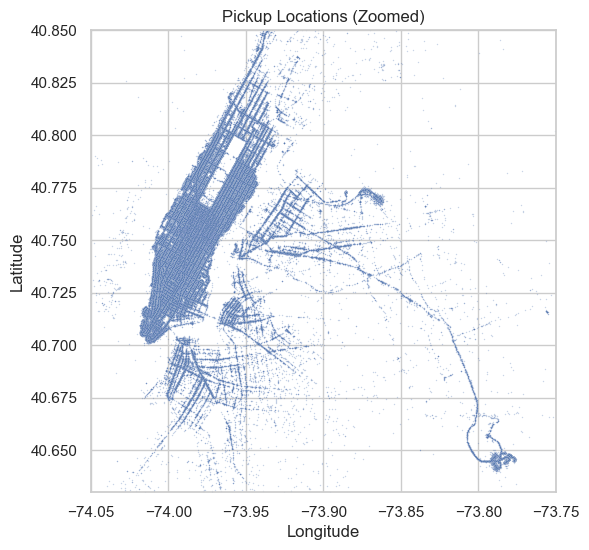

In [133]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=df['pickup_longitude'], y=df['pickup_latitude'], s=1, alpha=0.3)
plt.title('Pickup Locations (Zoomed)')
plt.xlim(-74.05, -73.75)
plt.ylim(40.63, 40.85)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

**Northwest Region:**
Encompasses Midtown and Downtown Manhattan, featuring dense taxi activity and a well-organized grid street layout.

**Southeast Region:**
Includes the JFK Airport area, where trips generally follow long, curved routes toward the airport.

In [134]:
get_featurs_details('trip_duration')

count    1.229264e+06
mean     9.596529e+02
std      5.263130e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

trip_duration
368      1357
417      1352
348      1349
424      1343
367      1340
         ... 
5063        1
5820        1
4826        1
85402       1
4988        1
Name: count, Length: 7146, dtype: int64



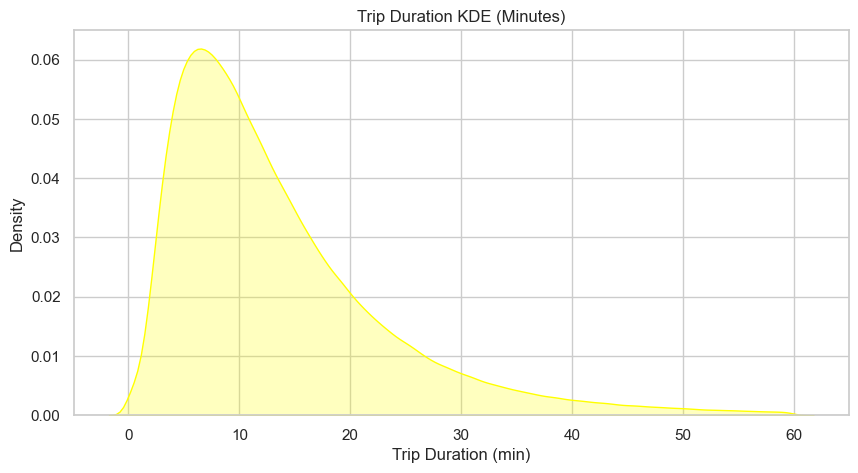

In [135]:
# Convert to minutes
df['trip_duration_min'] = df['trip_duration'] / 60

# Filter out outliers (keep trips < 60 minutes)
df_filtered = df[df['trip_duration_min'] < 60]

plt.figure(figsize=(10, 5))
sns.kdeplot(df_filtered['trip_duration_min'], fill=True, color='yellow')
plt.title('Trip Duration KDE (Minutes)')
plt.xlabel('Trip Duration (min)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

- Observation : In this dataset, the target variable `trip_duration` is measured in seconds and is highly skewed â€” most trips are short, but a few take several hours (or more). To better visualize and model the data, we apply a logarithmic transformation. "`log_trip_duration` = log(Trip Duration + 1)"

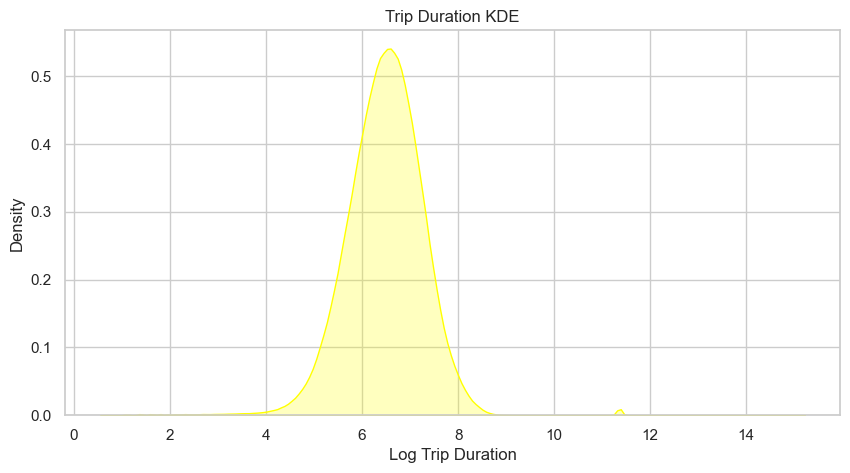

In [136]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])

plt.figure(figsize=(10, 5))
sns.kdeplot(df['log_trip_duration'], fill=True, color='yellow')
plt.title('Trip Duration KDE')
plt.xlabel('Log Trip Duration')
plt.ylabel('Density')
plt.grid(True)
plt.show()

The target variable `trip_duration` shows heavy clustering at very short times (e.g., one second) and extreme outliers (up to 40.8Â days), which are unrealistic. We remove these outliers to focus on plausible trips. Due to its strong right-skewness, we apply a log transformation to create `log_trip_duration`, stabilizing variance and improving correlation analysis. This transformation significantly enhances the usefulness of the data for modeling.

In [137]:
df.select_dtypes(include = 'object').describe().T


count   unique                  top     freq
pickup_datetime     1229264  1173085  2016-01-12 18:48:44        5
store_and_fwd_flag  1229264        2                    N  1222449

Among the non-numerical variables, we have `pickup_datetime` and `store_and_fwd_flag`. The `pickup_datetime` feature contains a large number of unique values, and its current string format is not easily interpretable or suitable for analysis. To address this, we will convert it into a proper datetime format, which will allow us to extract more meaningful time-based features such as hour, day of the week, or month.


In [138]:
get_featurs_details('store_and_fwd_flag')

count     1229264
unique          2
top             N
freq      1222449
Name: store_and_fwd_flag, dtype: object

store_and_fwd_flag
N    1222449
Y       6815
Name: count, dtype: int64



The `store_and_fwd_flag` feature is heavily imbalanced, with the vast majority of values being `'N'`. This skewed distribution suggests that the feature carries limited predictive value, as it is dominated by a single category. While we can apply one-hot encoding to maintain consistency in preprocessing, it is likely that this feature will contribute little to the modelâ€™s performance â€” and may ultimately be dropped after further evaluation.


In [139]:
get_featurs_details('pickup_datetime')

count                 1229264
unique                1173085
top       2016-01-12 18:48:44
freq                        5
Name: pickup_datetime, dtype: object

pickup_datetime
2016-01-12 18:48:44    5
2016-05-07 13:18:07    5
2016-04-05 18:55:21    5
2016-03-14 17:19:59    4
2016-02-16 21:11:15    4
                      ..
2016-04-25 22:46:54    1
2016-04-23 18:40:35    1
2016-05-09 08:47:57    1
2016-04-25 19:20:24    1
2016-02-08 19:38:00    1
Name: count, Length: 1173085, dtype: int64



# Anaylsis of Temporal Features

In [140]:
# Convert 'pickup_datetime' to datetime format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract time-related features from 'pickup_datetime'
df['hour'] = df['pickup_datetime'].dt.hour
df['minute'] = df['pickup_datetime'].dt.minute
df['second'] = df['pickup_datetime'].dt.second

# Extract date-related features
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['weekday'] = df['pickup_datetime'].dt.weekday  # 0 = Monday, 6 = Sunday
df['day_of_year'] = df['pickup_datetime'].dt.dayofyear

# Identify period boundaries
df['is_month_start'] = df['pickup_datetime'].dt.is_month_start.astype(int)
df['is_month_end'] = df['pickup_datetime'].dt.is_month_end.astype(int)
df['is_quarter_start'] = df['pickup_datetime'].dt.is_quarter_start.astype(int)
df['is_quarter_end'] = df['pickup_datetime'].dt.is_quarter_end.astype(int)

# Drop the original 'pickup_datetime' column
df.drop(columns='pickup_datetime', inplace=True)

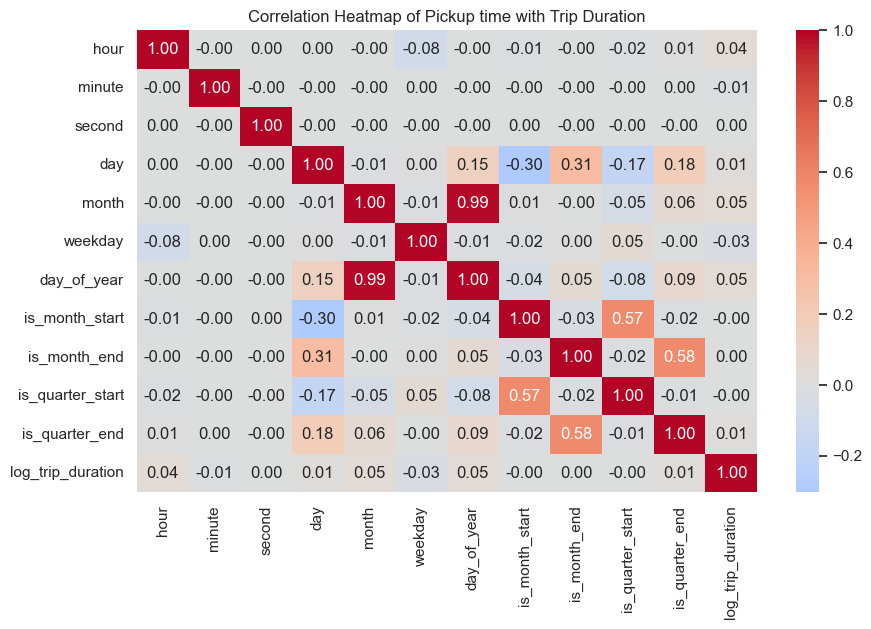

In [141]:
# Select datetime-derived columns + target
cols = [
    'hour', 'minute', 'second',
    'day', 'month', 'weekday',
    'day_of_year', 
    'is_month_start', 'is_month_end',
    'is_quarter_start', 'is_quarter_end',
    'log_trip_duration'
]

# Compute correlation matrix
corr_matrix = df[cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title("Correlation Heatmap of Pickup time with Trip Duration")
plt.show()

### Summary of Correlation Analysis

Correlation analysis of time- and date-related features informed feature selection and engineering:

* **`second`** was removed due to noise and minimal predictive value.
* **`minute`** showed slight negative correlation but was kept with one-hot encoding to capture cyclical effects and improve model fit.
* **`hour`** exhibited weak positive correlation and was retained for creating meaningful time-of-day indicators (`is_morning`, `is_afternoon`, `is_night`).
* **`month`** and **`weekday`** provided subtle contextual signals, supporting features like `is_weekend`, `is_summer`, and `is_winter`.
* **`day_of_year`** was dropped as it introduced noise and degraded performance due to high cardinality.
* Period boundary flags (**`is_month_start`**, **`is_quarter_end`**, **`pickup_quarter_end`**) had mixed effects; some were kept based on empirical results.

Correlation was a useful but limited guideâ€”low-correlation features may still hold predictive value, so final decisions relied on experimentation and iterative refinement.



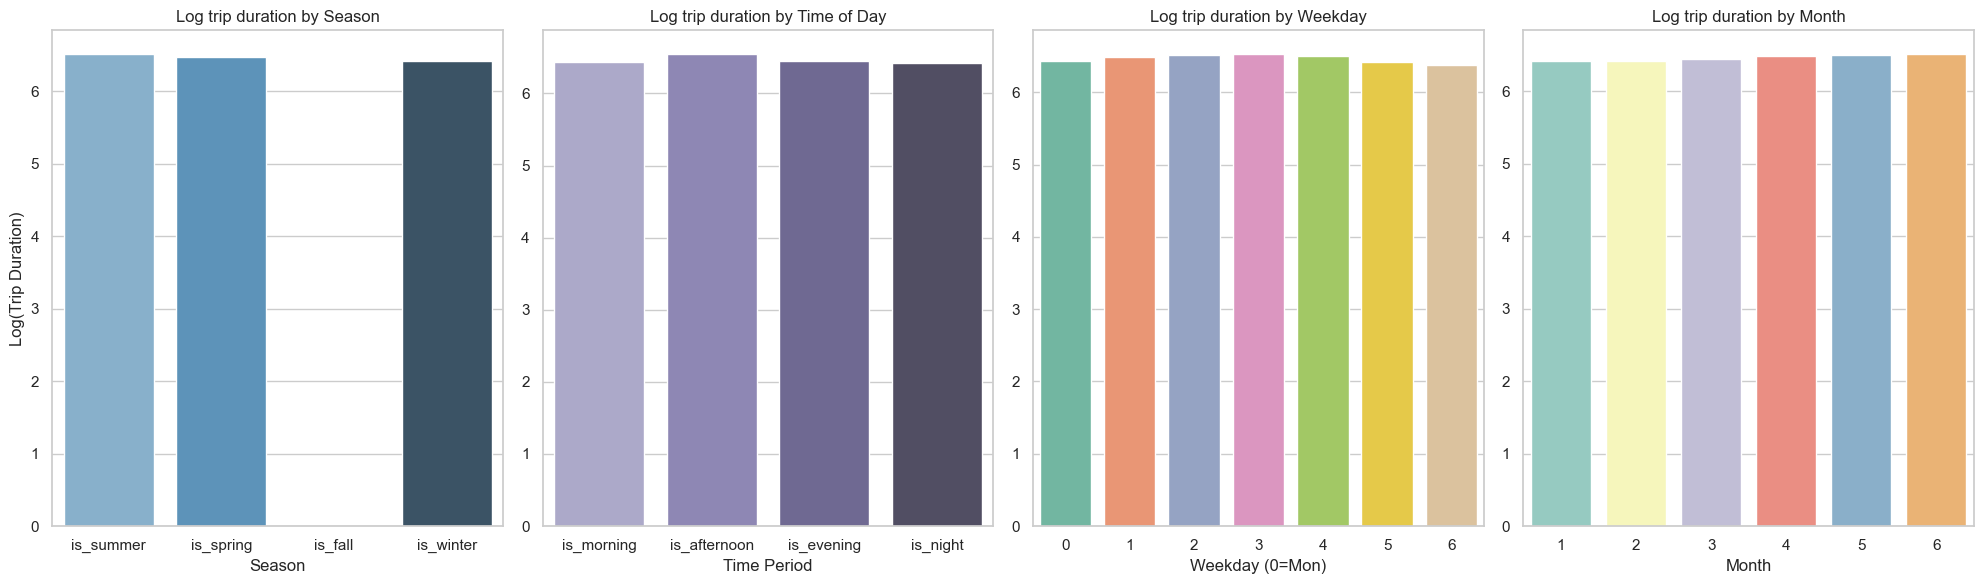

In [142]:
time_df = df[['weekday', 'month', 'hour', 'log_trip_duration']].copy()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 6))

# Helper function to prepare data for barplot: filter flag=1 and average log_trip_duration by category
def prepare_barplot_data(df, flag_dict, flag_name):
    records = []
    for name, condition in flag_dict.items():
        # Select rows where condition is True
        filtered = df[condition]
        mean_val = filtered['log_trip_duration'].mean()
        records.append({flag_name: name, 'log_trip_duration': mean_val})
    return pd.DataFrame(records)

# 1. Seasonal Flags computed on the fly
season_flags = {
    'is_summer': time_df['month'].isin([6, 7, 8]),
    'is_spring': time_df['month'].isin([3, 4, 5]),
    'is_fall': time_df['month'].isin([9, 10, 11]),
    'is_winter': time_df['month'].isin([12, 1, 2]),
}
season_avg = prepare_barplot_data(time_df, season_flags, 'season')

plt.subplot(1, 4, 1)
sns.barplot(data=season_avg, x='season', y='log_trip_duration', hue='season', palette='Blues_d', legend=False)
plt.title("Log trip duration by Season")
plt.xlabel("Season")
plt.ylabel("Log(Trip Duration)")

# 2. Time of Day Flags computed on the fly
time_flags = {
    'is_morning': (time_df['hour'] >= 6) & (time_df['hour'] < 12),
    'is_afternoon': (time_df['hour'] >= 12) & (time_df['hour'] < 18),
    'is_evening': (time_df['hour'] >= 18) & (time_df['hour'] < 21),
    'is_night': (time_df['hour'] >= 20) | (time_df['hour'] <= 5),
}
time_avg = prepare_barplot_data(time_df, time_flags, 'time_period')

plt.subplot(1, 4, 2)
sns.barplot(data=time_avg, x='time_period', y='log_trip_duration', hue='time_period', palette='Purples_d', legend=False)
plt.title("Log trip duration by Time of Day")
plt.xlabel("Time Period")
plt.ylabel("")

# 3. Weekday average log_trip_duration
weekday_avg = time_df.groupby('weekday')['log_trip_duration'].mean().reset_index()

plt.subplot(1, 4, 3)
sns.barplot(data=weekday_avg, x='weekday', y='log_trip_duration', hue='weekday', palette='Set2', legend=False)
plt.title("Log trip duration by Weekday")
plt.xlabel("Weekday (0=Mon)")
plt.ylabel("")

# 4. Month average log_trip_duration
month_avg = time_df.groupby('month')['log_trip_duration'].mean().reset_index()

plt.subplot(1, 4, 4)
sns.barplot(data=month_avg, x='month', y='log_trip_duration', hue='month', palette='Set3', legend=False)
plt.title("Log trip duration by Month")
plt.xlabel("Month")
plt.ylabel("")

plt.tight_layout()
plt.show()


* **Seasonal Variation:**
  Analyzing seasonal patterns, we observe that trip durations are longest during the **summer**, followed by **spring**, and shortest in **winter**. This trend can be attributed to the nature of **summer vacations**, where people are more likely to take longer trips. A similar, though less pronounced, effect is seen in spring.

* **Time of Day:**
  When looking at the time of day, the **afternoon** period records the longest trip durations, followed by **evening**, **morning**, and **night**. Although the differences are subtle, this pattern likely reflects **heavier traffic during the afternoon**, which is typically the busiest time of day as people commute home from work or school.

* **Weekday Trends:**
  Analyzing weekdays, trip durations tend to **increase gradually from Monday to Thursday**, then **decline toward the weekend**, reaching the **lowest on Sunday**. Overall, **weekdays have higher trip durations compared to holidays**, which can again be explained by **increased weekday traffic** and daily commuting routines.


# Analysis of Categorical Features

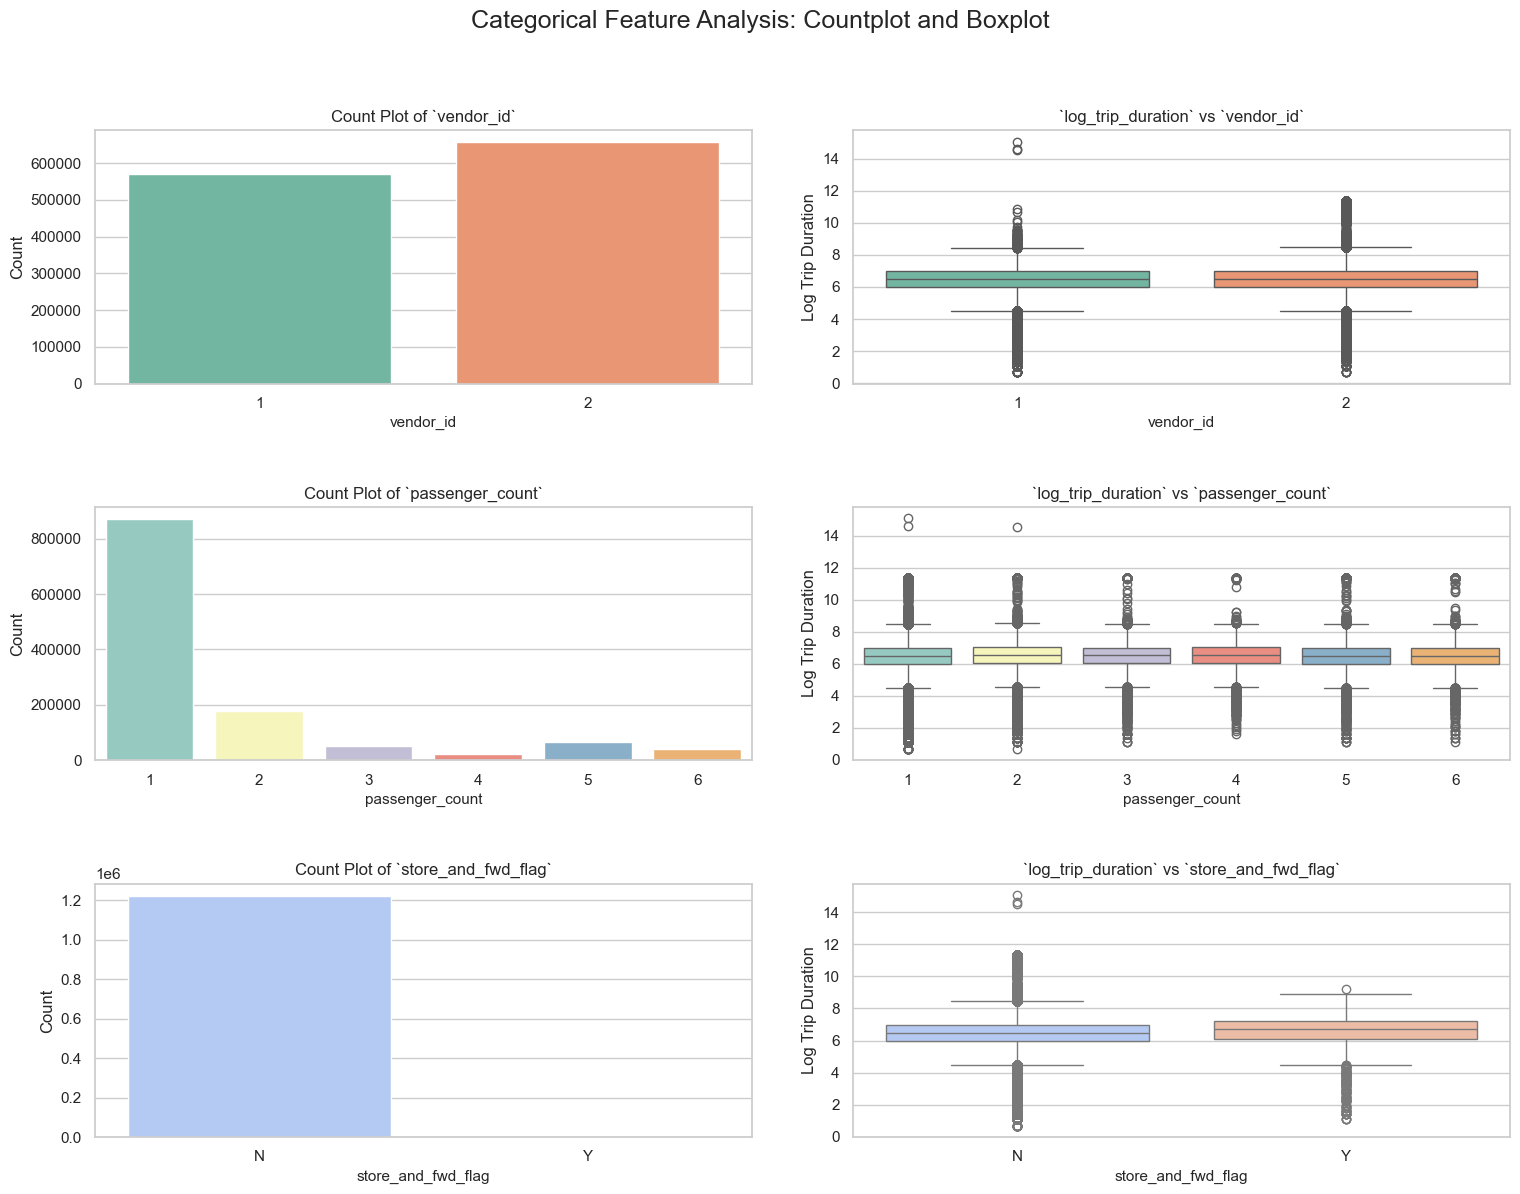

In [143]:
categorical_features = ['vendor_id', 'passenger_count', 'store_and_fwd_flag']
palettes = ['Set2', 'Set3', 'coolwarm']

# Create a figure with 3 rows and 2 columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
fig.suptitle("Categorical Feature Analysis: Countplot and Boxplot", fontsize=18, y=1.02)

for i, (feature, palette) in enumerate(zip(categorical_features, palettes)):
    # Countplot
    sns.countplot(
        data=df,
        x=feature,
        hue=feature,
        palette=palette,
        ax=axes[i, 0],
        legend=False
    )
    axes[i, 0].set_title(f'Count Plot of `{feature}`', fontsize=12)
    axes[i, 0].set_xlabel(feature, fontsize=11)
    axes[i, 0].set_ylabel('Count')

    # Boxplot
    sns.boxplot(
        data=df,
        x=feature,
        y='log_trip_duration',
        hue=feature,
        palette=palette,
        ax=axes[i, 1],
        legend=False
    )
    axes[i, 1].set_title(f'`log_trip_duration` vs `{feature}`', fontsize=12)
    axes[i, 1].set_xlabel(feature, fontsize=11)
    axes[i, 1].set_ylabel('Log Trip Duration')

# Improve layout
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92)  # Allow space for the main title
plt.show()


From the analysis of categorical variables in relation to **`log_trip_duration`**, we observe the following:

* **`vendor_id`**: Both vendors show similar usage frequencies, with a slight tendency for trips under **`vendor_id` = 2** to have longer durations on average. This might reflect differences in service areas or operational patterns between the two vendors.

* **`passenger_count`**: Most trips involve a single passenger, which is the dominant case. As **`passenger_count`** increases, the number of trips sharply decreases, while the average trip duration tends to increase. This pattern suggests that typical trips with 1 to 3 passengers have normal durations, whereas trips with higher passenger counts often last longerâ€”possibly indicating trips to airports, group travel, or special occasions.

* **`store_and_fwd_flag`**: The vast majority of trips have a flag value of **â€˜Nâ€™**, indicating no store-and-forward activity. Although trips with **â€˜Yâ€™** are rare, they tend to have higher average `log_trip_duration`, suggesting these longer trips might occur in areas with poor network connectivity, requiring data to be stored and forwarded later. Due to this significant imbalance and the distinct nature of these trips, **`store_and_fwd_flag`** will probably be dropped from the model to avoid potential noise and imbalance issues.

# Outlier Removal and Data Cleaning

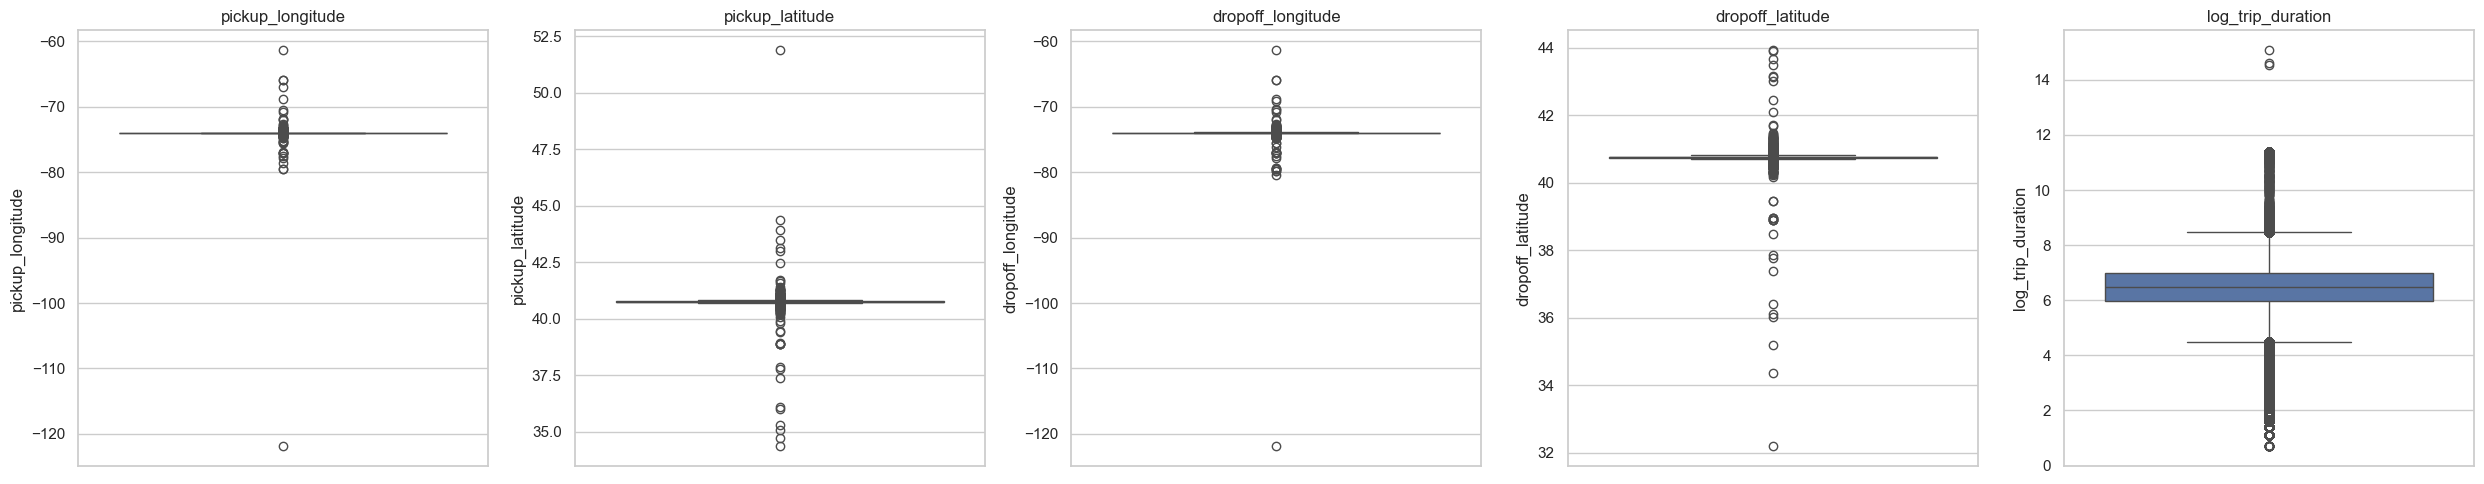

In [144]:

cols_to_plot = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'log_trip_duration']

plt.figure(figsize=(5 * len(cols_to_plot), 5))  # Width proportional to number of cols

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(1, len(cols_to_plot), i)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.tight_layout()

plt.show()


### **Outlier Analysis and Removal Strategy**

Boxplots for `pickup_latitude`, `pickup_longitude`, `dropoff_latitude`, `dropoff_longitude`, and `log_trip_duration` revealed extreme outliers that could skew model training and reduce generalization.

We used the **Interquartile Range (IQR) method** to remove outliers, defining acceptable values as:

$$
[Q_1 - k \times \text{IQR}, \quad Q_3 + k \times \text{IQR}]
$$

where \$k\$ controls outlier removal strictness.

---

### **IQR Multiplier Experiments**

| Dataset Size | IQR Multiplier \$k\$ | RÂ² Score    |
| ------------ | -------------------- | ----------- |
| Small        | 1.5                  | 0.59761     |
| Large        | 1.5                  | 0.60875     |
| Small        | 5                    | 0.66249     |
| Large        | 5                    | 0.66249     |
| Small        | 10                   | **0.69234** |
| Large        | 10                   | 0.68808     |

---

### **Key Takeaways**

* The default k = 1.5 was too strict, removing valuable data and hurting performance.
* Higher k values (5, 10) improved results by retaining more valid trips.
* The best performance on the large training set was at **k = 8**, balancing noise removal with preserving legitimate long trips.
* Taxi data includes valid extreme trips (e.g., airport rides), so overly aggressive filtering harms model learning.
* Careful tuning of k is essential to avoid discarding meaningful data while reducing noise.


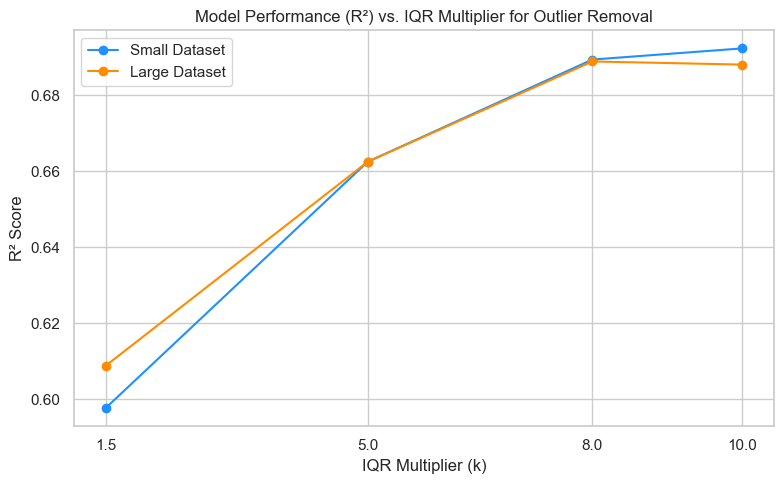

In [145]:
# Updated IQR multipliers
multipliers = [1.5, 5, 8, 10]

# New RÂ² scores from the screenshot
r2_small = [0.59761, 0.66249,  0.68940, 0.69234]
r2_large = [0.60875, 0.66249, 0.68890, 0.68808]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(multipliers, r2_small, marker='o', label='Small Dataset', color='dodgerblue')
plt.plot(multipliers, r2_large, marker='o', label='Large Dataset', color='darkorange')

# Labels and styling
plt.title('Model Performance (RÂ²) vs. IQR Multiplier for Outlier Removal')
plt.xlabel('IQR Multiplier (k)')
plt.ylabel('RÂ² Score')
plt.xticks(multipliers)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Effect of IQR Multiplier on Model Performance**

This plot shows how different IQR multipliers affect the modelâ€™s RÂ² score on small and large datasets.

* The **IQR multiplier (k)** controls how strictly outliers are removed:

  * Lower k values (e.g., 1.5) remove more data points aggressively.
  * Higher k values (e.g., 10) retain more data by allowing wider ranges.

* **Observations**:

  * Increasing k improves RÂ² on both datasets.
  * The large dataset benefits the most, reaching RÂ² = 0.68890 at k = 8.
  * The small dataset shows modest but consistent gains.

* Using a strict outlier filter (low k) can discard valuable data. A **softer filter (higher k)** better balances noise reduction and data retention, leading to improved accuracy.


In [146]:
def clean_outliers(df, col, multiplier = 1.5):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    
    df_no_outliers = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df_no_outliers

In [147]:
columns_to_clean = [
    'dropoff_latitude',
    'dropoff_longitude',
    'pickup_latitude',
    'pickup_longitude',
    'log_trip_duration'
]

for col in columns_to_clean:
    df = clean_outliers(df, col)


### ðŸ”’ **Note on Real-World IQR Application**

Just for clarification, while we use the IQR method to remove outliers, itâ€™s important to emphasize that:

> ðŸ”’ **The lower and upper bounds must be computed from the training dataset only.**

In real-time or production settings, we wonâ€™t have access to the full distribution of incoming data to recompute new bounds. Therefore, the IQR thresholds derived from the training data serve as our **reference boundaries** for cleaning or filtering any future data, whether it's from a validation set or live stream.

This ensures:

* Consistency between training and inference
* Avoidance of data leakage
* Realistic, production-ready preprocessing

So even though we clean the validation or test sets, we do so using the same statistical thresholds learned from the training setâ€”**just as a real system would handle unseen data**.


# Analysis of Spatial Features

### **Core Spatial Insight: Distance as a Representative Feature**

To capture the spatial aspect of each trip, we engineered the **trip distance** using the **Haversine formula**, which effectively combines pickup and dropoff coordinates into a single, meaningful metric. Among all spatial features, this distanceâ€”and its non-linear variants (`distance_squared`, `log_trip_distance`)â€”proved to be the **most informative**, significantly improving model performance.

These transformations allowed the model to better capture **non-linear effects** between distance and duration, resulting in **notable increases in RÂ² score**. Given its predictive power and ability to represent both pickup and dropoff locations in one variable, **distance was chosen as the primary spatial feature** for the final model.

> While using multiple forms of the same feature can introduce **multicollinearity**, empirical testing showed clear performance gains, reaffirming that **data-driven validation should guide feature selection**, especially in real-world applications.

In [148]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df['trip_distance'] = haversine_distance(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude']
)
df['trip_distance_squared'] = df['trip_distance'] ** 2
df['log_trip_distance'] = np.log1p(df['trip_distance'])

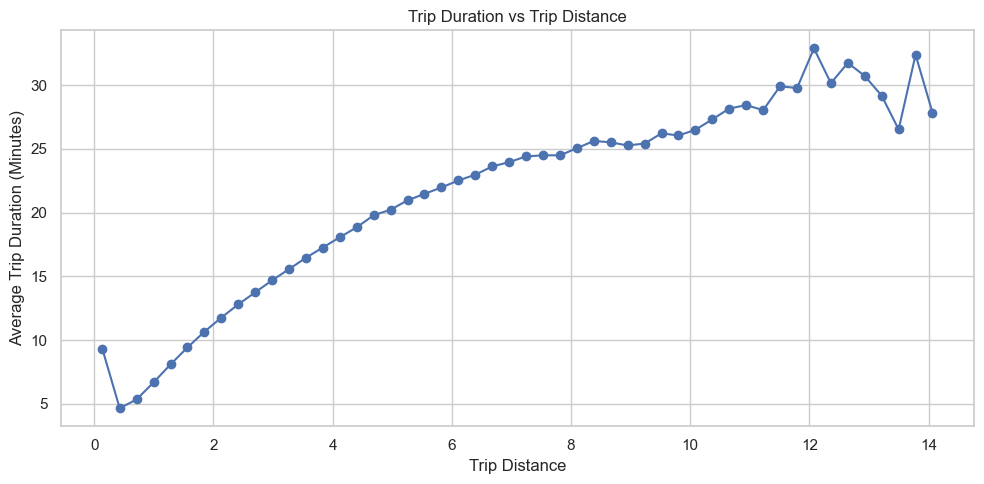

In [149]:
# Bin trip distances into intervals (e.g., every 0.5 miles/km)
df['distance_bin'] = pd.cut(df['trip_distance'], bins=50)

# Compute the average trip_duration for each distance bin
grouped = df.groupby('distance_bin', observed=False)['trip_duration_min'].mean().reset_index()


# Convert interval bin to midpoint for plotting
grouped['distance_mid'] = grouped['distance_bin'].apply(lambda x: x.mid)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(grouped['distance_mid'], grouped['trip_duration_min'], marker='o', linestyle='-')
plt.xlabel('Trip Distance')
plt.ylabel('Average Trip Duration (Minutes)')
plt.title('Trip Duration vs Trip Distance')
plt.grid(True)
plt.tight_layout()
plt.show()

We observe a general trend where **trip duration increases with distance**, as expected. However, for **shorter trips**, we see instances where travel time is **longer than for slightly farther trips**. This anomaly is likely due to **traffic congestion** in **dense urban areas**, where **frequent stops, traffic lights, and passenger pickups** can disproportionately affect short-distance travel times.

In contrast, for **longer distances**, the graph exhibits a **zigzag pattern**, reflecting **fluctuations in duration**. These variations can be attributed to **environmental and infrastructural factors** such as **highway availability, road conditions, speed limits, and varying traffic patterns** along different routes. These external influences introduce **non-uniformity** in the relationship between distance and duration.


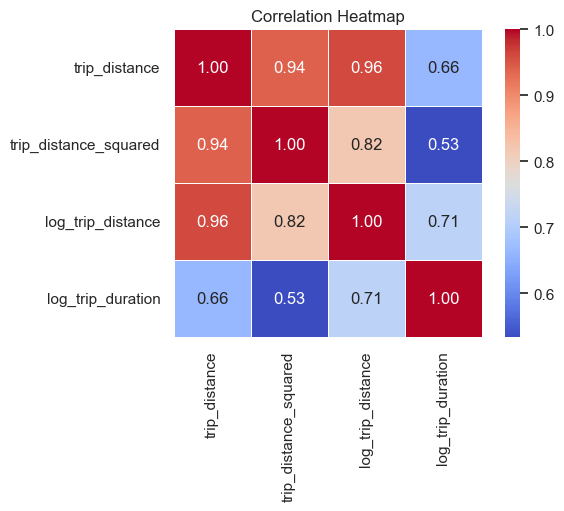

In [150]:
# -------- Correlation Heatmap
plt.figure(figsize=(6, 4))
corr = df[['trip_distance', 'trip_distance_squared', 'log_trip_distance', 'log_trip_duration']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)
plt.title('Correlation Heatmap')
plt.show()

We examined the **correlation coefficients** between different non-linear transformations of `trip_distance` and the target variable `log_trip_duration`. Among them, the **log-transformed distance (`log_trip_distance`)** showed the **strongest correlation**, outperforming the raw `trip_distance`. This highlights the value of log transformation in **reducing skewness** and emphasizing meaningful patterns in the data.

Although `distance_squared` showed the **weakest correlation**, it still contributed positively to model performance. Each transformation captures **different aspects of the non-linear relationship** between distance and duration, providing the modelâ€”particularly **linear models like Ridge Regression**â€”with **richer representations** of spatial behavior. This multi-angle approach helps compensate for the modelâ€™s inability to capture non-linearity on its own.

> In summary, all variants of the distance feature proved valuable, and their combined use significantly enhanced the modelâ€™s predictive power.


# Feature Engineering

### Engineered Features

This section summarizes the engineered features developed to enhance model performance by capturing meaningful spatial, temporal, and behavioral patterns in the dataset.

---

#### Distance-Based Features

* **`trip_distance`**
  Haversine distance (in kilometers) between pickup and dropoff locations.

* **`trip_distance_squared`**
  Squared trip distance to model potential non-linear relationships.

* **`log_trip_distance`**
  Log-transformed distance to reduce skewness and stabilize variance.

---

#### Time-Based Binary Features

* **`is_weekend`**
  Flags trips occurring on weekends (Saturday or Sunday).

* **`is_night`**
  Flags trips during night hours (8 PM to 5 AM).

* **`is_morning`**
  Flags trips in the morning period (6 AM to 12 PM).

* **`is_afternoon`**
  Flags trips during the afternoon period (12 PM to 6 PM).

* **`is_evening`**
  Flags trips in the early evening period (6 PM to 9 PM).

---

#### Seasonal Flags

* **`is_summer`**
  Indicates trips during June, July, or August.

* **`is_spring`**
  Indicates trips during March, April, or May.

* **`is_winter`**
  Indicates trips during December, January, or February.

---

#### Interaction Features

* **`night_and_weekend`**
  Flags trips that occurred at night during weekends.

* **`weekend_times_month`**
  Captures the interaction between weekends and seasonal trends.

* **`hour_x_is_night`**
  Models the hour of the trip only if it occurred at night.

* **`hour_times_weekend`**
  Time of day weighted by the weekend indicator.

* **`month_times_weekend`**
  Month weighted by weekend status, integrating seasonality and weekly cycles.

---

#### Spatial Features

* **`latitude_sum`**
  Sum of pickup and dropoff latitudes, indicating a general northâ€“south spatial component.

* **`longitude_sum`**
  Sum of pickup and dropoff longitudes, representing eastâ€“west positioning.

* **`distance_times_latitude_sum`**
  Interaction between trip distance and latitude sum to capture regional distance dynamics.

* **`distance_times_longitude_sum`**
  Similar interaction with longitude to reflect location-based distance variation.

---

#### Passenger & Vendor Interactions

* **`vendor_passenger_interaction`**
  Combines vendor ID with passenger count to reveal vendor-specific behavior patterns.

* **`hour_x_passenger_count`**
  Models the relationship between time of day and number of passengers.

* **`trip_distance_x_passenger_count`**
  Helps identify group travel trends by scaling distance with passenger count.

* **`trip_distance_x_weekday`**
  Explores how trip distances vary across different days of the week.

## Key Conclusions from Feature Engineering

The feature engineering process involved iterative testing and refinement to determine which transformations and combinations added real value to the model. Below are the most important takeaways:

---

### What Didnâ€™t Work

* Features derived from **heavily imbalanced binary variables** or **dominant categories** provided little to no predictive power.

* **Over-engineered combinations** and unnecessary mathematical transformations often had minimal impact or even reduced model performance.

* Some **intuitively reasonable time-based flags** (e.g., rush hour indicators) did not improve the model, likely because their patterns were already captured by other temporal features.

---

### What Proved Effective

* Simplifying complex inputs, such as **summarizing spatial context** instead of using raw location coordinates, yielded better results.

* Applying **non-linear transformations** and creating **interaction features**â€”particularly those involving variables already correlated with the targetâ€”helped capture important patterns.

* **Cross-feature interactions** between categorical and continuous variables revealed nuanced relationships that were not visible in isolated features.

---

### Final Insight

The most impactful features were those that:

* Reflected **real-world relationships**, such as spatial layout, trip length, and temporal dynamics.
* Applied **mathematically appropriate transformations** to address skewness or non-linearity.
* Were **evaluated through model performance**, not just intuition.

> In the end, effective feature engineering is grounded in experimentation, empirical validation, and a clear understanding of the dataâ€™s structure and context.